# 3 - Development Phase

In [1]:
# Author information
__author__ = "Troy Reynolds"
__email__ = "Troy.Lloyd.Reynolds@gmail.com"

In [2]:
### Libraries
# standard packages
import pandas as pd
import numpy as np
import sys
import inspect

# pipeline creation
from sklearn.pipeline import Pipeline

# model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Add data_storage and helper_functions to directory
sys.path.insert(0, "./data_storage")
sys.path.insert(0, "./helper_functions")

# helper functions
from reporting import dtype_selector
from file_management import data_import, save_model
from preprocessing import Preprocessing, Imputer, Feature_Transformation
from visualization import plot_model_results, plot_feature_importance
from model_eval import cv_mse_stats, threshold_testing

# Load Data

In [3]:
train_data = data_import("train")
features = train_data.drop("Exited", axis = 1)
labels = train_data["Exited"]
train_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
2151,2152,15588614,Walton,753.0,West,Male,57,7,0.00,1,1,0,159475.08,1
8392,8393,15641158,Belcher,739.0,East,Male,32,3,102128.27,1,1,0,63981.37,1
5006,5007,15750014,Chikere,755.0,East,Female,37,0,113865.23,2,1,1,117396.25,0
4117,4118,15663964,Pagnotto,561.0,West,Male,37,5,0.00,2,1,0,83093.25,0
7182,7183,15573520,Rhodes,692.0,East,Male,49,6,110540.43,2,0,1,107472.99,0


# Feature Engineering

#### <u>Preprocessing:</u>
1. Drop Feature ID's because they are not helpful to the model
2. Create a cutoff for age to accommadate outlier
3. Typecast integer features as floats for easy feature sorting later in the pipeline

In [4]:
### Print Documentation
print('\n{0:*^80}'.format(' Preprocessing Documentation '))
print(inspect.getsource(Preprocessing))

### Test
# transform features
prep = Preprocessing()
processed_features = prep.transform(features)

# print test results
print('\n{0:*^80}'.format(' Preprocessing Test '))
print("Max Age of Clients: {}\n".format(processed_features.Age.max()))
processed_features.head()


************************* Preprocessing Documentation **************************
class Preprocessing(BaseEstimator, TransformerMixin):
    """
    Prepare data for feature engineering step [Remove ID's, cap Age at 100]
    
    Parameters:
    remove_id: Boolean 
    cap_age: Boolean
    
    Methods:
    fit: required to sklearn pipeline
    transform: remove ID's and cap age
    """
    
    def __init__(self, remove_id = True, cap_age = True, typecast = True):
        self.remove_id = remove_id
        self.cap_age = cap_age
        self.typecast = typecast
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):        
        # remove id
        if self.remove_id:
            X_copy = X.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)
        
        # typecast
        if self.typecast:
            X_copy[["Age", "Tenure"]] = X[["Age", "Tenure"]].astype("float")
            
        # cap age at 100
        if self.cap_age:
 

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary
2151,753.0,West,Male,57.0,7.0,0.00,1,1,0,159475.08
8392,739.0,East,Male,32.0,3.0,102128.27,1,1,0,63981.37
5006,755.0,East,Female,37.0,0.0,113865.23,2,1,1,117396.25
4117,561.0,West,Male,37.0,5.0,0.00,2,1,0,83093.25
7182,692.0,East,Male,49.0,6.0,110540.43,2,0,1,107472.99


#### <u>Imputation:</u>
1. Categorical Strings: replace NAs with mode
2. Continuous floats: replace NAs with median
3. Categorical Integers: replace NAs with mode

In [5]:
### Print Documentation
print('\n{0:*^80}'.format(' Imputation Documentation '))
print(inspect.getsource(Imputer))

### Test
# transform features
imp = Imputer()
no_na_features = imp.fit_transform(processed_features, labels)

# print test results
print('\n{0:*^80}'.format(' Imputation Test '))
print('\n{0:*^80}'.format(' Before - Missing Values '))
print(processed_features.isnull().sum(axis = 0).sort_values(ascending = False))
print('\n{0:*^80}'.format(' After - Missing Values '))
print(no_na_features.isnull().sum(axis = 0).sort_values(ascending = False))
no_na_features.head()


*************************** Imputation Documentation ***************************
class Imputer(BaseEstimator, TransformerMixin):
    """
    Impute missing data based on feature type: [categorical string, continuous
    numeric, or categorical integers]
    
    methods:
    fit: gets column names according to feature type and trains the imputing column
         transformer
    
    transform: imputes missing values in the features and transform data back into
               dataframe
    """
    def fit(self, X, y = None):
        ### get the column names
        self.cat_cols = X.select_dtypes(include = "O").columns # categorical strings
        self.num_cols = X.select_dtypes(include = "float").columns # continuous numerical
        self.int_cols = X.select_dtypes(include = "int64").columns # categorical ints
        
        ### fit imputer column transformer
        self.imputer = ColumnTransformer([
            # Categorical Features 
            ("cat", SimpleImputer(strategy =

,Geography,Gender,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts,HasChckng,IsActiveMember
0,West,Male,753.0,57.0,7.0,0.00,159475.08,1,1,0
1,East,Male,739.0,32.0,3.0,102128.27,63981.37,1,1,0
2,East,Female,755.0,37.0,0.0,113865.23,117396.25,2,1,1
3,West,Male,561.0,37.0,5.0,0.00,83093.25,2,1,0
4,East,Male,692.0,49.0,6.0,110540.43,107472.99,2,0,1


#### <u>Feature Transformations:</u>
1. Categorical Strings: one-hot-encoded
2. Continuous floats: standardized

In [6]:
### Print Documentation
print('\n{0:*^80}'.format(' Feature_Transformation Documentation '))
print(inspect.getsource(Feature_Transformation))

### Test
# transform features
feature_transform = Feature_Transformation()
transformed_features = feature_transform.fit_transform(no_na_features, labels)

# print test results
print('\n{0:*^80}'.format(' Feature_Transformation Test '))
transformed_features.head()


********************* Feature_Transformation Documentation *********************
class Feature_Transformation(BaseEstimator, TransformerMixin):
    """
    Transforms features based on datatype: [Categorical string features are 
    one-hot-encoded and Numeric features are standardized]
    
    Methods:
    fit: seperates features based on type and fits the column transformer
    
    transform: transforms the data input and converts the output array to 
               a dataframe
    """
    def fit(self, X, y = None):
        # get column names
        self.cat_cols = X.select_dtypes(include = "O").columns
        self.num_cols = X.select_dtypes(include = "float").columns
        
        # create column transformer to one-hot-encode and standardize the data
        self.one_hot_and_scale = ColumnTransformer([
                ("cat", OneHotEncoder(drop = "first"), self.cat_cols),
                ("num", StandardScaler(), self.num_cols)],
                remainder = "passthrough" # 

,cat__Geography_East,cat__Geography_West,cat__Gender_Male,cat__Gender_Neutral,num__CreditScore,num__Age,num__Tenure,num__Balance,num__EstimatedSalary,remainder__NumOfProducts,remainder__HasChckng,remainder__IsActiveMember
0,0.0,1.0,1.0,0.0,1.059053,1.706532,0.68045,-1.226059,1.042084,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.914165,-0.658707,-0.69411,0.413288,-0.623556,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.079751,-0.185659,-1.72503,0.601687,0.308128,2.0,1.0,1.0
3,0.0,1.0,1.0,0.0,-0.927984,-0.185659,-0.00683,-1.226059,-0.290199,2.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.427755,0.949655,0.33681,0.548318,0.135042,2.0,0.0,1.0


#### <u>Feature pipeline for all models:</u>

In [7]:
# Pipeline
feature_pipeline = Pipeline([
    ("preprocess", Preprocessing()),
    ("impute", Imputer()),
    ("transform", Feature_Transformation())
])

# test
model_ready_features = feature_pipeline.fit_transform(features, labels)
model_ready_features.head()

,cat__Geography_East,cat__Geography_West,cat__Gender_Male,cat__Gender_Neutral,num__CreditScore,num__Age,num__Tenure,num__Balance,num__EstimatedSalary,remainder__NumOfProducts,remainder__HasChckng,remainder__IsActiveMember
0,0.0,1.0,1.0,0.0,1.059053,1.706532,0.68045,-1.226059,1.042084,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.914165,-0.658707,-0.69411,0.413288,-0.623556,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.079751,-0.185659,-1.72503,0.601687,0.308128,2.0,1.0,1.0
3,0.0,1.0,1.0,0.0,-0.927984,-0.185659,-0.00683,-1.226059,-0.290199,2.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.427755,0.949655,0.33681,0.548318,0.135042,2.0,0.0,1.0


# Model Development

#### <u>Baseline Model:</u>
The baseline model for this unbalanced classificatino problem is to assume that all clients will not churn. This will yield an 80% accuracy.

In [8]:
print("Accuracy of Baseline Model: {}".format(1 - labels.mean()))

Accuracy of Baseline Model: 0.79625


#### <u>Logistic Regression (Log Reg):</u>
After the logistic regression was tuned and fitted, different thresholds were tested to find the optimal cuttoff. The best threshold was at 0.2. Though accuracy was reduced by 10% and precision was reduced by 20%, recall increased by 50% which increases the amount of churned clients by over 3-fold.

In [9]:
#### Find best hyperparameters
# Initialize model
log_cl = LogisticRegression()

# param_grid
param_log = [{
    "C": [0.01, 0.03, 0.1, 0.3, 1],
    "max_iter": [50, 80, 100, 150, 200, 300],
    "random_state": [42]
}]

# initialize grid search
grid_search_log = GridSearchCV(
    log_cl, 
    param_log,
    scoring = "accuracy",
    cv = 5, 
    n_jobs = 4, 
    verbose = 1
)

# run grid search
%time grid_search_log.fit(model_ready_features, labels)
print("Best Parameters: ", grid_search_log.best_params_)
print("Best Accuracy:   ", grid_search_log.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Wall time: 3.43 s
Best Parameters:  {'C': 0.03, 'max_iter': 50, 'random_state': 42}
Best Accuracy:    0.8115


In [10]:
### Find best threshold
log_results = threshold_testing(
    model_ready_features, 
    labels, 
    LogisticRegression(**grid_search_log.best_params_), 
    "Log Reg"
)

print(log_results)

### Record Results
model_results = np.array(log_results.iloc[1, [0, 2, 3, 4]])

     Model Threshold accuracy precision  recall
0  Log Reg       0.1   0.4555    0.2621  0.9215
1  Log Reg       0.2   0.6962    0.3706  0.7025
2  Log Reg       0.3    0.786    0.4756   0.484
3  Log Reg       0.4   0.8029    0.5286  0.3025
4  Log Reg       0.5   0.8115     0.627  0.1853
5  Log Reg       0.6   0.8041    0.6463  0.0834
6  Log Reg       0.7   0.7986     0.603  0.0288
7  Log Reg       0.8   0.7962    0.5833  0.0061


#### <u>K Nearest Neighbors (KNN):</u>
Similar to the Logistic regression, the best cuttoff is at 0.2. The KNN model experienced the same increase to recall and suffered less reduction in percision and accuracy.

In [11]:
#### Find best hyperparameters
# Initialize model
knn_cl = KNeighborsClassifier(
    algorithm = "auto",
    p = 2, # euclidean distance
)

# param_grid
param_knn = [{
    "weights": ["uniform", "distance"],
    "n_neighbors": [5, 8, 10, 12, 15, 20, 25]
}]

# initialize grid search
grid_search_knn = GridSearchCV(
    knn_cl, 
    param_knn,
    scoring = "accuracy",
    cv = 5, 
    n_jobs = 4, 
    verbose = 1
)

# run grid search
%time grid_search_knn.fit(model_ready_features, labels)
print("Best Parameters: ", grid_search_knn.best_params_)
print("Best Accuracy:   ", grid_search_knn.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Wall time: 3.85 s
Best Parameters:  {'n_neighbors': 10, 'weights': 'distance'}
Best Accuracy:    0.83475


In [12]:
### Find best threshold
knn_results = threshold_testing(
    model_ready_features, 
    labels, 
    KNeighborsClassifier(**grid_search_knn.best_params_), 
    "KNN"
)

print(knn_results)

### Record Results
results = np.array(knn_results.iloc[1, [0, 2, 3, 4]])
model_results = np.concatenate((model_results, results)).reshape(2, len(results))

  Model Threshold accuracy precision  recall
0   KNN       0.1   0.6366     0.339  0.8245
1   KNN       0.2   0.7535    0.4353  0.7043
2   KNN       0.3   0.8072    0.5254  0.5706
3   KNN       0.4    0.832     0.619  0.4583
4   KNN       0.5   0.8348    0.6951  0.3374
5   KNN       0.6   0.8286    0.7638  0.2307
6   KNN       0.7    0.822    0.8383  0.1571
7   KNN       0.8   0.8118    0.9186   0.084


#### <u>Random Forest (RF):</u>
Similar to the Logistic regression and K-Nearest Neighbors, the best cuttoff is at 0.2. The Random Forest model experienced a larger increase to recall and suffered less reduction in percision and accuracy than the last 2 models.

In [13]:
#### Find best hyperparameters
# Initialize model
rf_cl = RandomForestClassifier()

# param_grid
param_rf = [{
    "n_estimators": [75, 100, 200],
    "max_depth": [12, 16, 20],
    "min_samples_split": [8, 10, 12],
    "max_features": ["sqrt"], # default
    "random_state": [42]
}]

# initialize grid search
grid_search_rf = GridSearchCV(
    rf_cl, 
    param_rf,
    scoring = "accuracy",
    cv = 5, 
    n_jobs = 4, 
    verbose = 1
)

# run grid search
%time grid_search_rf.fit(model_ready_features, labels)
print("Best Parameters: ", grid_search_rf.best_params_)
print("Best Accuracy:   ", grid_search_rf.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Wall time: 37.9 s
Best Parameters:  {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Best Accuracy:    0.8661249999999999


In [14]:
### Find best threshold
rf_results = threshold_testing(
    model_ready_features, 
    labels, 
    RandomForestClassifier(**grid_search_rf.best_params_), 
    "RF"
)

print(rf_results)

### Record Results
results = np.array(rf_results.iloc[1, [0, 2, 3, 4]]).reshape((1, 4))
model_results = np.concatenate((model_results, results))

  Model Threshold accuracy precision  recall
0    RF       0.1   0.6031     0.329  0.9117
1    RF       0.2   0.7696    0.4614  0.7785
2    RF       0.3    0.837    0.5888  0.6663
3    RF       0.4   0.8582    0.6978  0.5399
4    RF       0.5   0.8661    0.7971  0.4607
5    RF       0.6   0.8584    0.8444  0.3736
6    RF       0.7   0.8464     0.884  0.2834
7    RF       0.8   0.8286    0.9388  0.1706


#### <u>XgBoost:</u>
Similar to the other models, the best cuttoff is at 0.2. The Xgboost model experienced a similar increase to recall like the Random Forest model, but suffered less reduction in percision and accuracy than all other models. The Xgboost model has a 1% decrease in accuracy compared to the baseline, but correctly identifies 78% of clients that have the potential to churn.

In [15]:
### Grid Search to get the best params
xgb_cl = XGBClassifier(use_label_encoder = False, eval_metric='logloss')

param_xgb = [{
    "max_depth": [5, 7, 9],
    "n_estimators": [20, 30, 40],
    "learning_rate": [0.1, 0.3],
    "min_child_weight": [1, 3, 5],
    "reg_lambda": [0.01, 0.03], # L2 regularization
    "reg_alpha": [0.01, 0.03], # L1 regularization
    "subsample": [0.8],
    "random_state": [42]
}]

grid_search_xgb = GridSearchCV(
    xgb_cl, 
    param_xgb,
    scoring = "accuracy", 
    cv = 5,
    n_jobs = 4,                          
    verbose = 1
)

# run grid search
%time grid_search_xgb.fit(model_ready_features, labels)
print("Best Parameters: ", grid_search_xgb.best_params_)
print("Best MSE:        ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Wall time: 1min 41s
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 30, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.8}
Best MSE:         0.865


In [16]:
### Find best threshold
xgb_results = threshold_testing(
    model_ready_features, 
    labels, 
    XGBClassifier(use_label_encoder = False, eval_metric='logloss', **grid_search_xgb.best_params_), 
    "Xgboost"
)

print(xgb_results)

### Record Results
results = np.array(xgb_results.iloc[1, [0, 2, 3, 4]]).reshape((1, 4))
model_results = np.concatenate((model_results, results))

     Model Threshold accuracy precision  recall
0  Xgboost       0.1   0.6129    0.3345  0.9086
1  Xgboost       0.2   0.7834    0.4805  0.7785
2  Xgboost       0.3   0.8346    0.5857  0.6472
3  Xgboost       0.4   0.8569    0.6849  0.5546
4  Xgboost       0.5    0.865    0.7776  0.4748
5  Xgboost       0.6    0.859    0.8227  0.3939
6  Xgboost       0.7   0.8525    0.8707  0.3252
7  Xgboost       0.8   0.8397    0.9131  0.2362


# Model Results
As shown below in the barplots, the Xgboost Classifier significantly outperforms the other models. The Xgboost model will be selected as the best model and will be used to classify the test data.

In [17]:
### turn results into a dataframe for plotting
model_results_df = pd.DataFrame(
    data = model_results, 
    columns = ["Model", "Accuracy", "Precision", "Recall"]
)

### typecast as float
float_cols = ["Accuracy", "Precision", "Recall"]
model_results_df[float_cols] = model_results_df[float_cols].astype("float")

### results
model_results_df

,Model,Accuracy,Precision,Recall
0,Log Reg,0.6962,0.3706,0.7025
1,KNN,0.7535,0.4353,0.7043
2,RF,0.7696,0.4614,0.7785
3,Xgboost,0.7834,0.4805,0.7785


Saving figure Model_Results


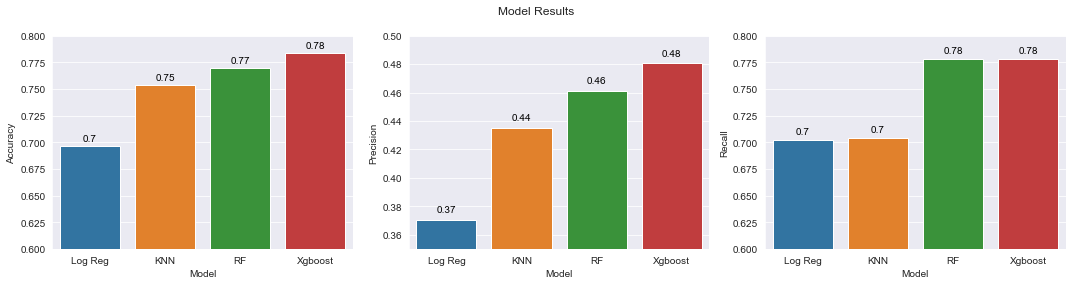

In [18]:
plot_model_results(model_results_df)

# Save Best Model and Pipeline and Feature Importance

In [19]:
# train xgboost model on entire training data
best_model = XGBClassifier(
    use_label_encoder = False, 
    eval_metric='logloss', 
    **grid_search_xgb.best_params_
)

best_model.fit(model_ready_features, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0.01,
              reg_lambda=0.01, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Saving figure XGBOOST FEATURE IMPORTANCE


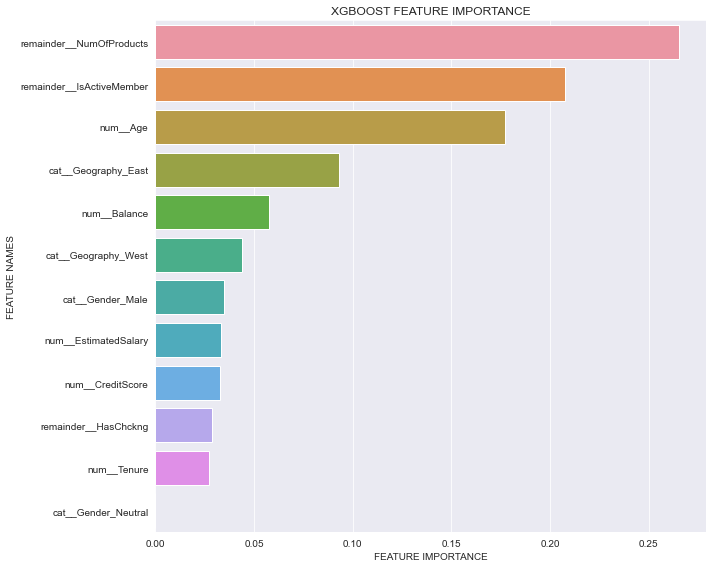

In [20]:
### Plot feature importance
importance = best_model.feature_importances_
names = model_ready_features.columns
plot_feature_importance(importance, names)

In [21]:
### Save pipeline
save_model(feature_pipeline, "pipeline")

### Save Model
save_model(best_model, "Xgboost")

Results Saved to .\model\pipeline.pkl
Results Saved to .\model\Xgboost.pkl


# Additions: Create a blender model

#### <u>Blender Model:</u>
Inputs: Log Reg, KNN, RF, Xgboost
Output: Logistic Regression

In [56]:
#### models
model_list = [
    LogisticRegression(**grid_search_log.best_params_),
    KNeighborsClassifier(**grid_search_knn.best_params_),
    RandomForestClassifier(**grid_search_rf.best_params_),
    XGBClassifier(use_label_encoder = False, eval_metric='logloss', **grid_search_xgb.best_params_)
]

save_model(model_list, "model_list")

Results Saved to .\model\model_list.pkl
